In [1]:
import math
import collections

import pandas as pd

from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import *

import params
from utils.sequence_data import generator_for_binary_classifier, generator_to_samples_and_targets
from utils.metrics import print_report_for_binary_classfier
from utils.preprocessing import probs_to_binary_classes
from utils.hyperparams import hyperparams_search
from utils.plot import plot_train_validation_metric

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv("../datasets/data_for_models/dataset_1996-01-01_2019-08-22.csv",
                           header=0, parse_dates=[0], index_col=0)

#params for generator
label_index = len(dataset.columns) -1
input_shape = (params.LOOKBACK//params.STEP, dataset.shape[-1] )

In [3]:
train_max_idx = math.ceil(len(dataset)*params.TRAIN_RATIO)
val_max_idx = math.ceil(len(dataset)*(params.TRAIN_RATIO+params.VAL_RATIO))

# 1 step = 1 batche of samples 
train_steps = (train_max_idx+1 -params.LOOKBACK) // params.BATCH_SIZE
val_steps =  (val_max_idx - train_max_idx - params.LOOKBACK) // params.BATCH_SIZE
test_steps = (len(dataset) - val_max_idx - params.LOOKBACK) // params.BATCH_SIZE

In [4]:
#init generator_for_binary_classifiers
train_gen = generator_for_binary_classifier(dataset.to_numpy(),
                      label_index=label_index,
                      lookback=params.LOOKBACK,
                      delay=params.DELAY,
                      min_index=0,
                      max_index=train_max_idx,
                      shuffle=False,
                      step=params.STEP, 
                      batch_size=params.BATCH_SIZE,
                      interval_label=True)



val_gen = generator_for_binary_classifier(dataset.to_numpy(),
                    label_index=label_index,
                      lookback=params.LOOKBACK,
                      delay=params.DELAY,
                      min_index=train_max_idx+1,
                      max_index=val_max_idx,
                      shuffle=False,
                      step=params.STEP, 
                      batch_size=params.BATCH_SIZE,
                      interval_label=True)

test_gen = generator_for_binary_classifier(dataset.to_numpy(),
                      label_index=label_index,
                      lookback=params.LOOKBACK,
                      delay=params.DELAY,
                      min_index=val_max_idx+1,
                      max_index=None,
                      shuffle=False,
                      step=params.STEP, 
                      batch_size=params.BATCH_SIZE,
                      interval_label=True)


In [5]:
def fc_model(hidden_unit, n_layer, l2_weight, input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    
    for _ in range(n_layer):
        model.add(Dense(hidden_unit, activation='relu', kernel_regularizer=regularizers.l2(l2_weight)))
        
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
best_params = hyperparams_search(model_func=fc_model, 
                                 input_shape=input_shape,
                                 train_steps=train_steps, 
                                 val_steps=val_steps, 
                                 train_gen=train_gen, 
                                 val_gen=val_gen, 
                                 num_epoch=3000,
                                 hidden_units=[16,32,64], 
                                 n_layers=[2,3], 
                                 l2_weights=[0,0.0005,0.001, 0.0015])
print(best_params)

KeyboardInterrupt: 

{'epochs': 1048, 'n_layer': 3, 'hidden_unti': 32, 'l2_weight': 0}

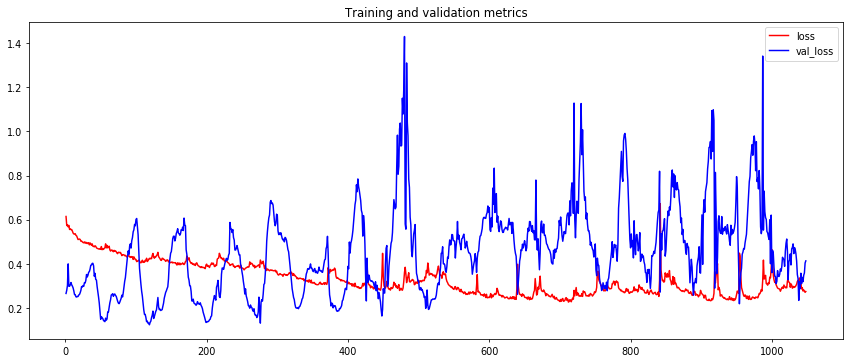

In [13]:
#hyperparameters
num_epoch = best_params['epochs'] 
n_layer= best_params['n_layer'] 
hidden_unit=best_params['hidden_unti']  
l2_weight=best_params['l2_weight']
                    

model = fc_model(hidden_unit, n_layer, l2_weight, input_shape)

# #fit the model
history = model.fit_generator(train_gen,
                    steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=num_epoch, verbose=0)

plot_train_validation_metric(history, 'loss', 'val_loss')

### We have 2984 positive and 984 negtive cases. 

In [14]:
#Make predictions for train set
    
X, Y = generator_to_samples_and_targets(train_gen, train_steps)    
Y_pred = model.predict(X)
print(collections.Counter(Y))
print_report_for_binary_classfier(Y, probs_to_binary_classes(Y_pred))

Counter({0.0: 3048, 1.0: 984})
F1 score: 0.756196
precision score: 0.873502
recall score: 0.666667
accuracy score: 0.895089
matthews_corrcoef: 0.701127

Confusion matrix:
[[2953   95]
 [ 328  656]]


In [15]:
#Make predictions from dev set
X, Y = generator_to_samples_and_targets(val_gen, val_steps)    
Y_pred = model.predict(X)
print(collections.Counter(Y))
print_report_for_binary_classfier(Y, probs_to_binary_classes(Y_pred))

Counter({0.0: 821, 1.0: 11})
F1 score: 0.033058
precision score: 0.018182
recall score: 0.181818
accuracy score: 0.859375
matthews_corrcoef: 0.016952

Confusion matrix:
[[713 108]
 [  9   2]]


In [16]:
#Make predictions for test set
X, Y = generator_to_samples_and_targets(test_gen, test_steps)    
Y_pred = model.predict(X)
print(collections.Counter(Y))
print_report_for_binary_classfier(Y, probs_to_binary_classes(Y_pred))

Counter({0.0: 802, 1.0: 30})
F1 score: 0.303030
precision score: 0.277778
recall score: 0.333333
accuracy score: 0.944712
matthews_corrcoef: 0.275729

Confusion matrix:
[[776  26]
 [ 20  10]]


# Save the best model 

In [26]:
from keras.models import load_model

model.save(params.BEST_MODEL_PATH)  # creates a HDF5 file 'my_model.h5'